# <span style="color:#2a5885;">Optimisation with AeroMAPS</span>

This notebook presents a procedure to optimize transition scenarios within **AeroMAPS**.


## Import librairies and configuration

In [1]:
%matplotlib widget

import pandas as pd


from aeromaps import create_process

from aeromaps.core.gemseo import CustomDataConverter

from gemseo.algos.design_space import DesignSpace

from gemseo.algos.opt.scipy_local.settings.slsqp import SLSQP_Settings


import gemseo as gm
import warnings

from aeromaps.utils.functions import custom_logger_config

custom_logger_config(gm.configure_logger())

<RootLogger root (INFO)>

## Process Creation

In [2]:
# Custom constraint models are loaded from config_with_elasticity.yaml's models.customs section
process = create_process(
    configuration_file="data/config_with_elasticity.yaml",
    optimisation=True,
)

    INFO - 20:15:44: Loaded custom model 'blend_completeness_constraint' from '/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/notebooks/tutorials/optimize_a_scenario/custom_constraints.py'
    INFO - 20:15:44: Loaded custom model 'biomass_availability_constraint_trajectory' from '/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/notebooks/tutorials/optimize_a_scenario/custom_constraints.py'
    INFO - 20:15:44: Loaded custom model 'grid_electricity_availability_constraint_trajectory' from '/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/notebooks/tutorials/optimize_a_scenario/custom_constraints.py'
    INFO - 20:15:44: Loaded custom model 'biomass_availability_constraint_trajectory' from '/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/notebooks/tutorials/optimize_a_scenario/custom_constraints.py'
    INFO - 20:15:44: Loaded custom model 'grid_electricity_availability_constraint_trajectory' from '/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/notebooks/tutorials/optimize_a_sc

## Constraints Definition

In AeroMAPS, standard constraints are defined in the source code.
However, as explained in [`create_a_custom_process`](./../create_a_custom_process/examples_custom_process.ipynb),
you can define other constraints directly and add them to the set of models used.

### Standard Constraint Example

In the current version of AeroMAPS, a constraint for the **aviation carbon budget objective** is defined directly in:
```
aeromaps/models/optimisation/constraints
```

To set the value, use:
```python
process.parameters.aviation_carbon_budget_objective = your_value
```


In [3]:
# Carbon budget share
process.parameters.aviation_carbon_budget_objective = 2.4

### Custom Constraints Example

Energy pathways in AeroMAPS are defined generically using YAML configuration files.
**Most constraints depend on the user's specific choices and problem context.**
Therefore, it is best to define these directly in the notebook, tailored to the targeted use case.


In this example, we define constraints for **resource availability** and **pathway interactions** in a custom file:
```
custom_constraints.py
```
- `BlendCompletenessConstraint`
- `BiomassAvailabilityConstraintTrajectory`
- `GridElectricityAvailabilityConstraintTrajectory`

> **Note:**
> These constraints are loaded from the configuration file (`config.yaml`) under the `models.customs` section.
> Parameters can still be adjusted after process creation.
> Biomass and electricity availabilities are defined directly in the resource file.

For simplicity in this notebook, constraints are only enforced at **discrete time steps**.
We introduce the variable `enforcement_years`, defined below.

In [4]:
# # Biomass availability

process.parameters.grid_electricity_constraint_enforcement_years = [2030, 2035, 2040, 2045, 2050]
process.parameters.generic_biomass_availability_constraint_enforcement_years = [
    2030,
    2035,
    2040,
    2045,
    2050,
]
process.parameters.blend_completeness_constraint_enforcement_years = [2030, 2035, 2040, 2045, 2050]

### Point of entry in the elasticity loop

In [5]:
### Here as we are operating with a loop, we have to define initial values of an entry point, just as in use_varaible_demand example
process.parameters.price_elasticity = -0.9

process.parameters.airfare_per_rpk = pd.Series(
    0.082949239,
    index=range(process.parameters.historic_start_year, process.parameters.end_year + 1),
)

### Optimisation problem setup with GEMSEO

In [6]:
###### OPTIMISATION SETUP #######

# --- Base settings ---
process.gemseo_settings["scenario_type"] = "MDO"
process.gemseo_settings["formulation"] = "MDF"

# --- Define the Design Space ---
design_space = DesignSpace()

# Biofuel blending mandates
design_space.add_variable(
    name="generic_biofuel_mandate_share_values",
    size=3,
    lower_bound=[0.0, 0.0, 0.0],
    upper_bound=[1e-10, 100, 100],
    value=[1e-20, 14.68171346, 41.87052262],
)

# Electro-fuel blending mandates
design_space.add_variable(
    name="electrofuel_mandate_share_values",
    size=3,
    lower_bound=[0.0, 0.0, 0.0],
    upper_bound=[1e-10, 100, 100],
    value=[1e-20, 14.68171346, 41.87052262],
)

process.gemseo_settings["design_space"] = design_space

# --- Define the Objective ---
objective_name = "cumulative_total_airline_cost_discounted_obj"
process.gemseo_settings["objective_name"] = objective_name

# --- Create and Configure the Scenario ---
process.create_gemseo_scenario()

# --- Adjust the Objective (after scenario creation only)---

# Scale objective to the 1-10 interval for optimization
process.scenario.formulation.optimization_problem.objective *= 1e-13

# --- Add Constraints ---
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "biomass_trajectory_constraint",
    "grid_electricity_trajectory_constraint",
]
for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")

# --- Set Differentiation and Optimization Algorithm ---
process.scenario.set_differentiation_method("finite_differences")

slsqp_settings = SLSQP_Settings(
    max_iter=20,  # CAUTION: 20 set for quick automated test, use ~200 for full runs
    ftol_rel=0.001,
    ftol_abs=0.001,
    ineq_tolerance=0.015,
    normalize_design_space=True,
)

process.gemseo_settings["algorithm"] = slsqp_settings

# --- Adding design variables to the set of list types varaible (they are declared as ndarray but needed as lists within aeromaps functions) ---
CustomDataConverter._list_names.update(process.scenario.get_optim_variable_names())

In [7]:
warnings.filterwarnings("ignore")
process.compute()

    INFO - 20:15:45: *** Start MDOScenario execution ***
    INFO - 20:15:45: MDOScenario
    INFO - 20:15:45:    Disciplines: ASK BiomassAvailabilityConstraintTrajectory BlendCompletenessConstraint CO2Emissions CarbonBudgetConstraint CarbonBudgetConsumedShare CarbonOffset CarbonTax CumulativeCO2Emissions CumulativeCarbonOffset DetailedCo2Emissions DetailedCumulativeCO2Emissions DicountedScenarioCost DropInFuelConsumption DropInFuelDetailledConsumption DropinFuelConsumptionLiterPerPax100km ElectricConsumption EnergyCarriersMassicShares EnergyCarriersMeanLHV EnergyCarriersMeans EnergyConsumption EnergyIntensity EnergyResourceConsumption EnergyResourceConsumption EnergyUseChoice ExogenousCarbonPriceTrajectory FreightAircraftEfficiency GridElectricityAvailabilityConstraintTrajectory GrossCarbonBudget H2OEmissionIndex HydrogenConsumption KayaFactors LevelCarbonOffset LoadFactor LoadFactorEfficiencyCost NOxEmissionIndex NonDiscountedScenarioCost OperationalEfficiencyCost OperationsContrails

Running MDO


    INFO - 20:18:22:     25%|██▌       | 5/20 [02:36<07:50,  1.91 it/min, obj=0.0107]
 WARNING - 20:19:01: Optimization found no feasible point; the least infeasible point is selected.
    INFO - 20:19:01: Optimization result:
    INFO - 20:19:01:    Optimizer info:
    INFO - 20:19:01:       Status: 8
    INFO - 20:19:01:       Message: Positive directional derivative for linesearch
    INFO - 20:19:01:       Number of calls to the objective function by the optimizer: 0
    INFO - 20:19:01:    Solution:
 WARNING - 20:19:01:       The solution is not feasible.
    INFO - 20:19:01:       Objective: 0.010702889430185889
    INFO - 20:19:01:       Standardized constraints:
    INFO - 20:19:01:          aviation_carbon_budget_constraint = 0.4389786299723877
    INFO - 20:19:01:          biomass_trajectory_constraint = [7.26037129e-06 2.16534801e-01 4.03232565e-01 7.47626441e-01
    INFO - 20:19:01:  1.12339836e+00]
    INFO - 20:19:01:          blend_completeness_constraint = [0. 0. 0. 0. 

## Results

 WARNING - 20:19:02: Optimization found no feasible point; the least infeasible point is selected.
 WARNING - 20:19:02: Optimization found no feasible point; the least infeasible point is selected.
 WARNING - 20:19:02: Optimization found no feasible point; the least infeasible point is selected.


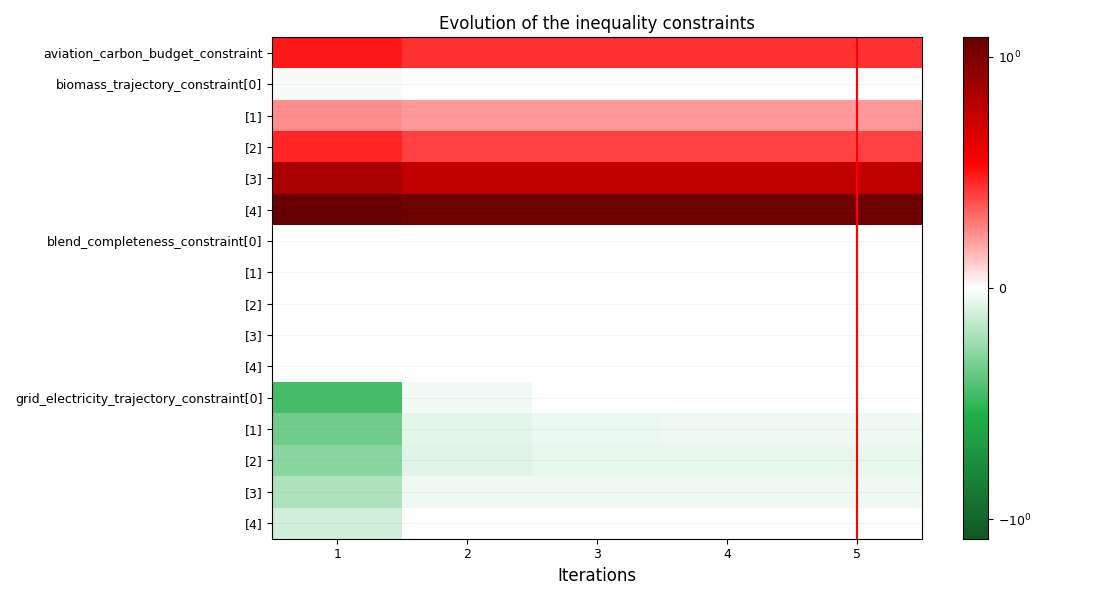

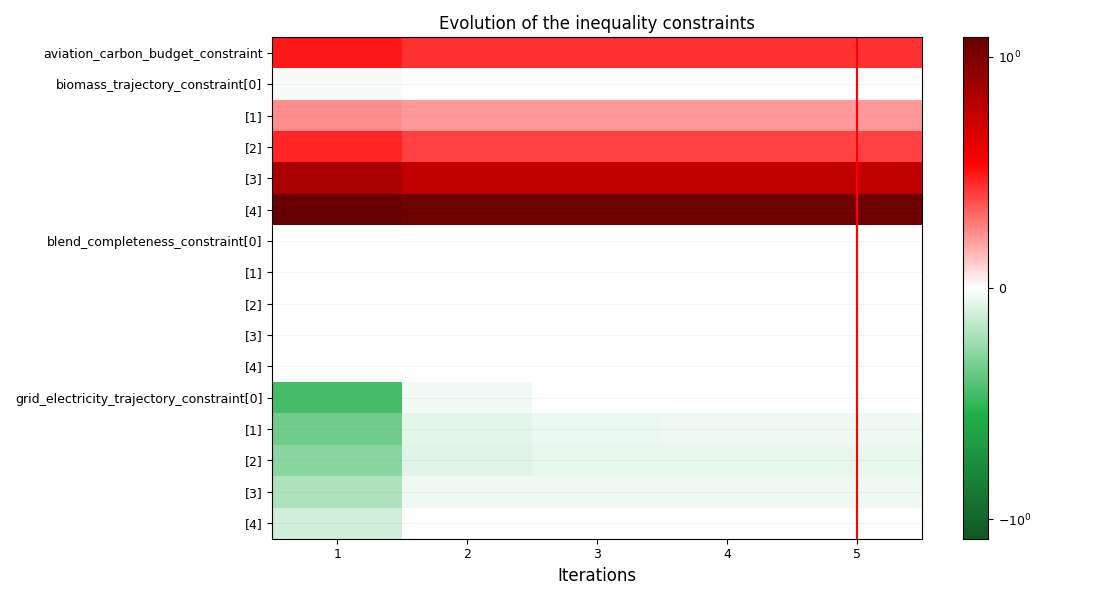

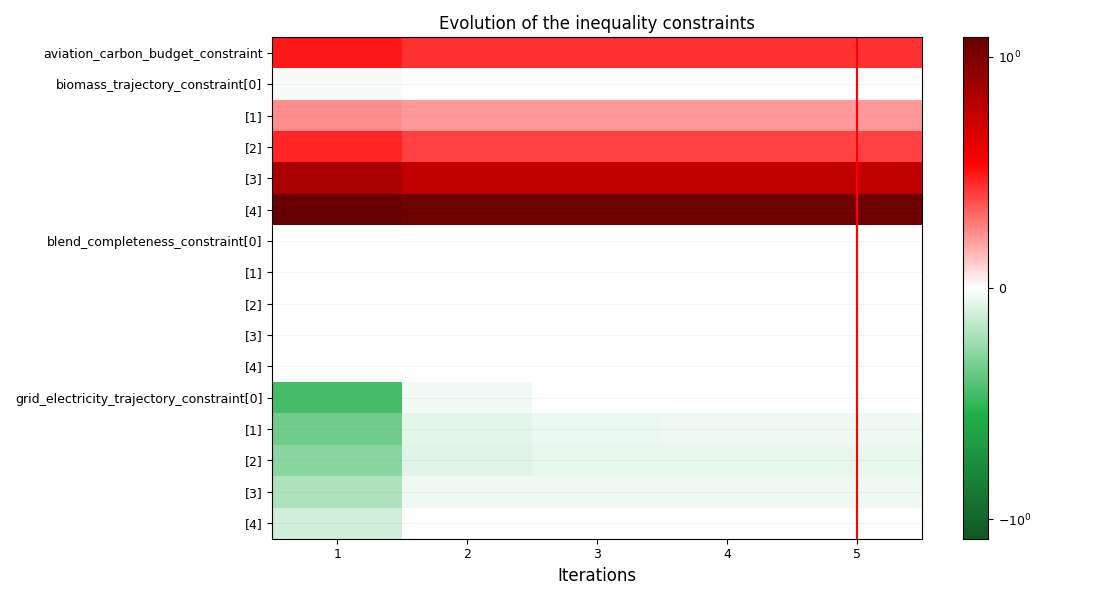

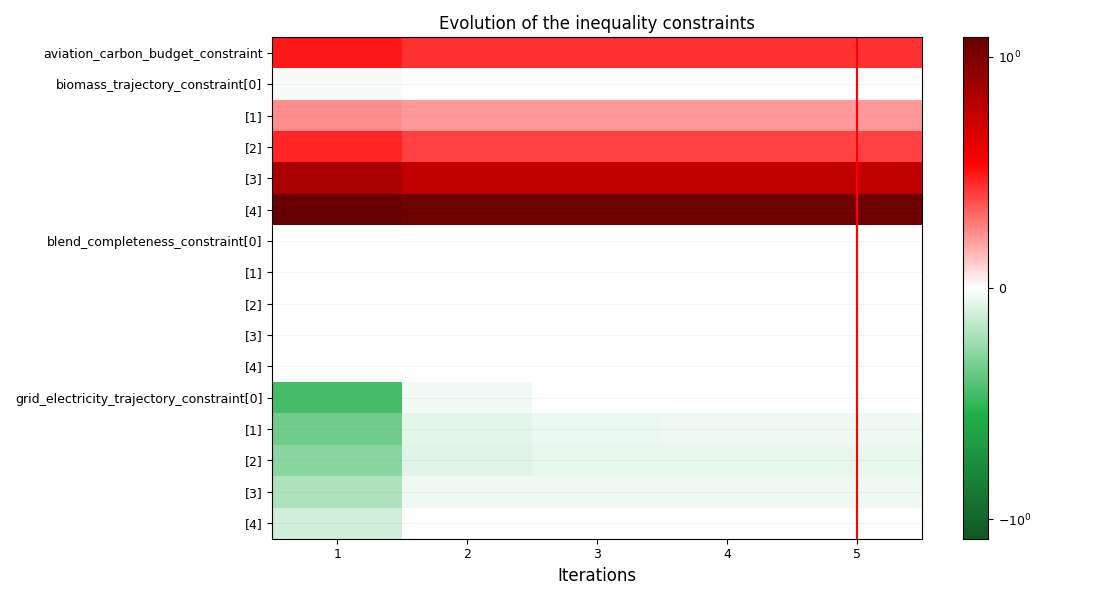

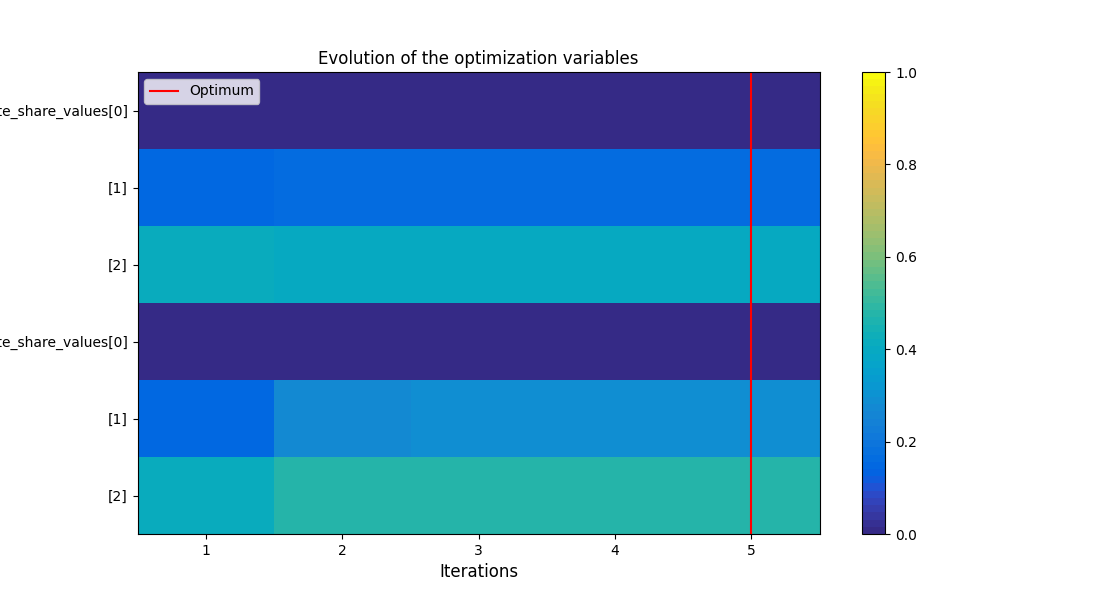

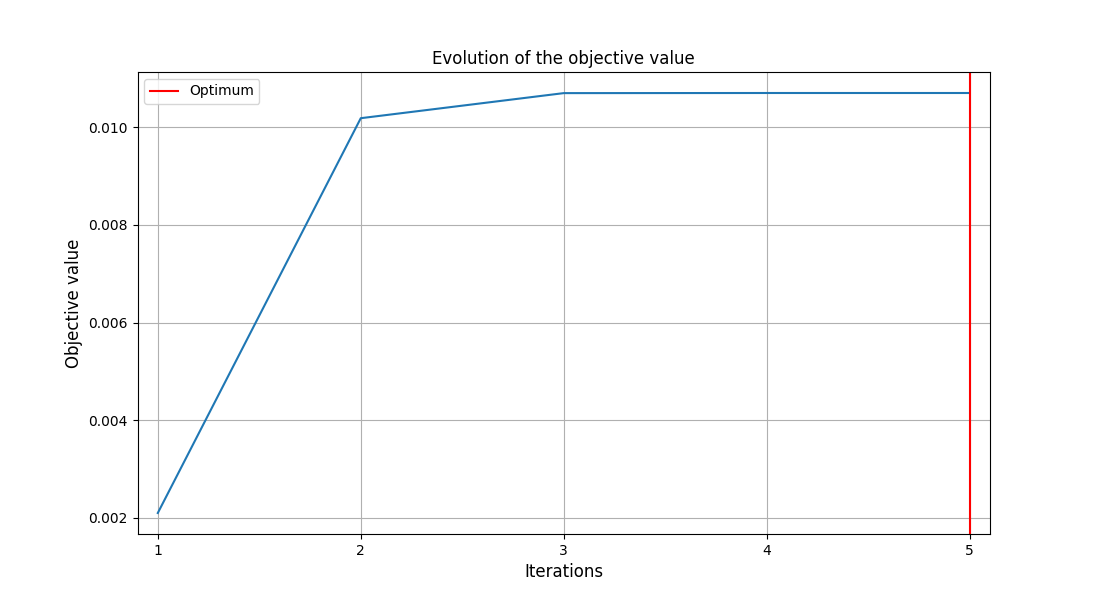

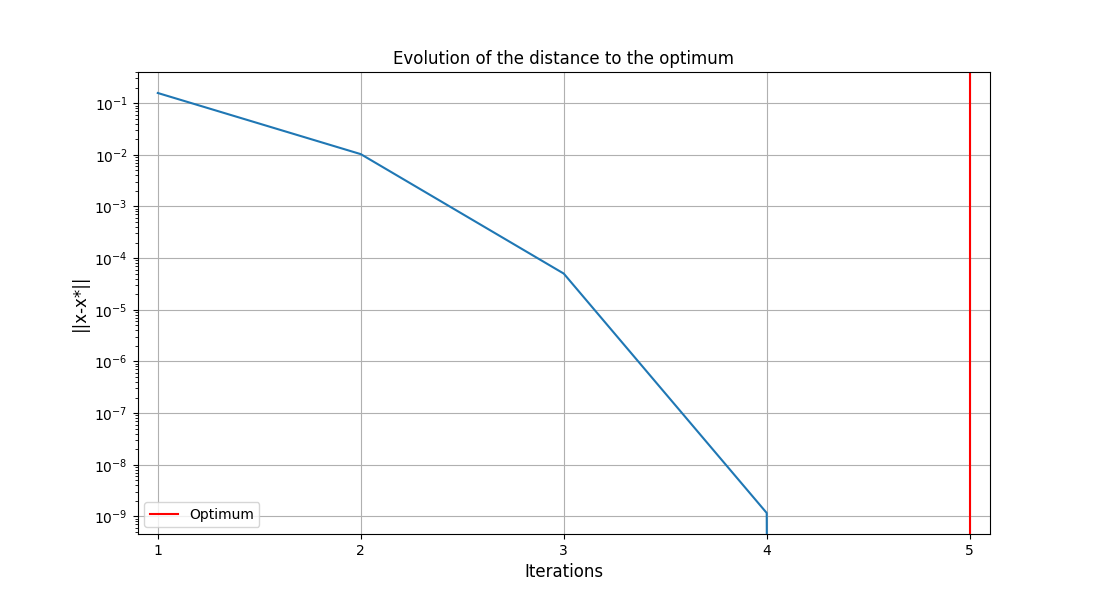

In [8]:
process.scenario.post_process(
    post_name="OptHistoryView",
    save=False,
    show=True,
)

In [9]:
process.scenario.get_result().design_variable_names_to_values

{'generic_biofuel_mandate_share_values': array([1.00000000e-20, 1.62014260e+01, 4.02293663e+01]),
 'electrofuel_mandate_share_values': array([1.00000000e-20, 2.89089297e+01, 4.81519897e+01])}

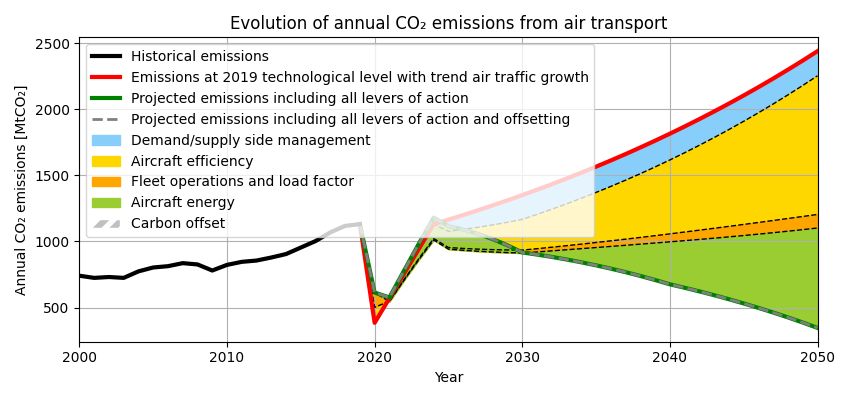

In [10]:
process.plot("air_transport_co2_emissions")

In [11]:
from aeromaps.utils.functions import clean_notebooks_on_tests

clean_notebooks_on_tests(globals())

    INFO - 20:19:05: 🧹 clean_notebooks_on_tests called
    INFO - 20:19:05: ⏭ Skipping cleanup during notebook run
    INFO - 20:19:05: ⏭ Skipping cleanup during notebook run
